# Training on a single GPU

In [4]:
%%sh
wget -nv https://azureailabs.blob.core.windows.net/aerialtfrecords/aerialsmall_train.tfrecords
wget -nv https://azureailabs.blob.core.windows.net/aerialtfrecords/aerialsmall_valid.tfrecords

2018-10-19 22:46:49 URL:https://azureailabs.blob.core.windows.net/aerialtfrecords/aerialsmall_train.tfrecords [532325045/532325045] -> "aerialsmall_train.tfrecords" [1]
2018-10-19 22:47:14 URL:https://azureailabs.blob.core.windows.net/aerialtfrecords/aerialsmall_valid.tfrecords [93062766/93062766] -> "aerialsmall_valid.tfrecords" [1]


In [22]:
import os

data_folder = 'datasets'
os.makedirs(data_folder, exist_ok=True)

In [23]:
import tensorflow as tf
tf.__version__

'1.11.0'

### Display examples of images

Read a few images from the training TFRecords file

In [25]:

def parse(example_proto):
    features = {'label': tf.FixedLenFeature((), tf.int64, default_value=0),
                'image': tf.FixedLenFeature((), tf.string, default_value="")}
    
    parsed_features = tf.parse_single_example(example_proto, features)
    label = parsed_features['label']
    image = image = tf.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, (224, 224, 3,))
    
    return image, label
    

files = ['aerialsmall_train.tfrecords']

dataset = tf.data.TFRecordDataset(files)
dataset = dataset.map(parse)
dataset = dataset.shuffle(1000)
iterator = dataset.make_one_shot_iterator()

images = []
labels = []
next_element = iterator.get_next()

for i in range(3):
    with tf.Session() as sess:
        image, label = sess.run(next_element)
        images.append(image)
        labels.append(label)
    

      

Display the images.

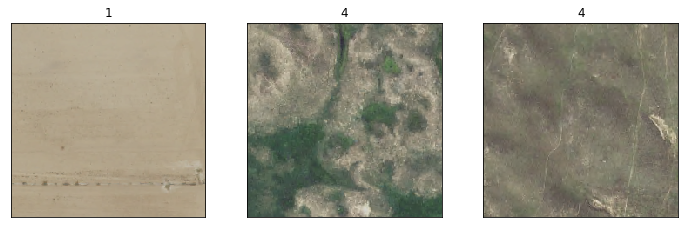

In [27]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

figsize=(10, 8)
fig, axis = plt.subplots(len(images)//3, 3, figsize=figsize)
fig.tight_layout()
image
for ax, image, label in zip(axis.flat[0:], images, labels):
    ax.set_title(str(label))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(image)

In [94]:
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image

# Returns a dataset based on a list of TFRecords files passsed as a parameters. 
def create_dataset(files, batch_size=32, train=True, buffer_size=10000):
  IMAGE_SHAPE = (224, 224, 3,)
  NUM_CLASSES = 6
  
  # Extract image and label from proto Example
  def _parse(example_proto):
      features = {'label': tf.FixedLenFeature((), tf.int64, default_value=0),
                'image': tf.FixedLenFeature((), tf.string, default_value="")}
      parsed_features = tf.parse_single_example(example_proto, features)
      label = parsed_features['label']
      label = tf.one_hot(label, NUM_CLASSES)
      image = image = tf.decode_raw(parsed_features['image'], tf.uint8)
      image = tf.cast(image, tf.float32)
      image = tf.reshape(image, IMAGE_SHAPE)
      
      # Pre-process image data for ResNet
      #   Substract the Imagenet mean for each channel
      imagenet_mean=np.array([103.939, 116.779, 123.68])
      #image = tf.divide(image, 127.5)
      image = tf.subtract(image, imagenet_mean)
        
      return image, label

  def _resnet_preprocess(images, labels):
      images = resnet50.preprocess_input(images)
      return images, labels

        
  dataset = tf.data.TFRecordDataset(files)
  dataset = dataset.map(_parse)
  if train:
      dataset = dataset.shuffle(buffer_size)
  dataset = dataset.batch(batch_size)
  #dataset = dataset.map(_resnet_preprocess)
  dataset = dataset.repeat()
  
  return dataset
    

In [101]:
import tensorflow as tf


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Input
from tensorflow.keras.regularizers import l1_l2

class Network():
    def __init__(self, classes=6, units=512, l1=0.01, l2=0.01):
        #self.base_model = InceptionV3(weights='imagenet', 
        #                         include_top=False,
        #                         input_shape=(224,224,3),
        #                         pooling='max')
        
        self.base_model = resnet50.ResNet50(
                weights = 'imagenet', 
                input_shape=(224,224,3), 
                include_top = False,
                pooling = 'avg')
        x = Dense(units, activation='relu')(self.base_model.output)
        x = Dropout(0.5)(x)
        y = Dense(classes, activation='softmax', kernel_regularizer=l1_l2(l1=l1, l2=l2))(x)
        self.model = Model(inputs=self.base_model.input, outputs=y)
    
    def freeze_all_base_layers(self):
        for layer in self.base_model.layers:
            layer.trainable = False
            
    def freeze_base_layers(self, num_of_layers):
        for layer in self.base_model.layers[:num_of_layers]:
            layer.trainable = False
        for layer in self.base_model.layers[num_of_layers:]:
            layer.trainable = True
            
    def get_model(self):
        return self.model
            
    

In [102]:
def get_num_of_records(file):
    c = 0
    for record in tf.python_io.tf_record_iterator(file):
        c += 1
        
    return c

In [103]:
network = Network()

network.freeze_all_base_layers()

model = network.get_model()
#model.summary()
optimizer = tf.train.AdadeltaOptimizer()
loss='categorical_crossentropy'
metrics=['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [105]:
batch_size = 32

train_files = ['aerialsmall_train.tfrecords']
train_batches = get_num_of_records(train_files[0])//batch_size

train_dataset = create_dataset(train_files, batch_size=batch_size)

valid_files = ['aerialsmall_valid.tfrecords']
valid_batches = get_num_of_records(valid_files[0])//batch_size

valid_dataset = create_dataset(valid_files, batch_size=batch_size, train=False)

print(train_batches)
print(valid_batches)

110
19


In [ ]:
model.fit(train_dataset, 
          epochs=100,  
          steps_per_epoch=train_batches,
          validation_data=valid_dataset,
          validation_steps=valid_batches)

Epoch 1/100
110/110 [==============================] - 10s 91ms/step - loss: 3.6566 - acc: 0.2528 - val_loss: 3.5627 - val_acc: 0.2072
Epoch 2/100
110/110 [==============================] - 10s 89ms/step - loss: 3.6464 - acc: 0.2607 - val_loss: 3.5526 - val_acc: 0.2220
Epoch 3/100
110/110 [==============================] - 10s 89ms/step - loss: 3.5739 - acc: 0.2765 - val_loss: 3.5338 - val_acc: 0.2253
Epoch 4/100
110/110 [==============================] - 10s 90ms/step - loss: 3.5668 - acc: 0.2934 - val_loss: 3.5142 - val_acc: 0.2368
Epoch 5/100
110/110 [==============================] - 10s 89ms/step - loss: 3.5126 - acc: 0.3124 - val_loss: 3.5035 - val_acc: 0.2451
Epoch 6/100
110/110 [==============================] - 10s 89ms/step - loss: 3.4847 - acc: 0.3170 - val_loss: 3.4834 - val_acc: 0.2615
Epoch 7/100
110/110 [==============================] - 10s 89ms/step - loss: 3.4557 - acc: 0.3223 - val_loss: 3.4638 - val_acc: 0.2895
Epoch 8/100
110/110 [==============================] - 